<a href="https://colab.research.google.com/github/KavindaRajapaksha/Brain-Tumor-Detection2024/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


dataset link :[link text](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

Reading the images

In [4]:
tumor=[]
path ='/content/drive/MyDrive/dataset/data/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
  img=cv2.imread(f)
  img=cv2.resize(img,(128,128))
  b,g,r =cv2.split(img)
  img=cv2.merge([r,g,b])
  tumor.append(img)



In [5]:
healthy=[]
path ='/content/drive/MyDrive/dataset/data/brain_tumor_dataset/no/*.jpg'
for f in glob.iglob(path):
  img=cv2.imread(f)
  img=cv2.resize(img,(128,128))
  b,g,r =cv2.split(img)
  img=cv2.merge([r,g,b])
  healthy.append(img)


In [6]:
len(healthy)

85

In [7]:
healthy=np.array(healthy)
tumor=np.array(tumor)
All=np.concatenate((healthy,tumor))

In [8]:
All.shape

(171, 128, 128, 3)

In [9]:
healthy.shape

(85, 128, 128, 3)

In [10]:
tumor.shape

(86, 128, 128, 3)

In [ ]:
np.random.choice(5,3)

array([1, 4, 2])

Visualize Brain MRI Images

In [28]:
def plot_random(healthy,tumor,num=5):
  healthy_imgs=healthy[np.random.choice(healthy.shape[0],num,replace=False)]
  tumor_imgs=tumor[np.random.choice(tumor.shape[0],num,replace=False)]
  plt.figure(figsize=(8,6))
  for i in range(num):
    plt.subplot(1,num,i+1)
    plt.title('healthy')
    plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(8,6))
  for i in range(num):
    plt.subplot(1,num,i+1)
    plt.title('tumor')
    plt.imshow(tumor_imgs[i])

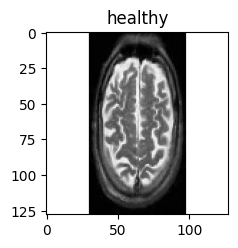

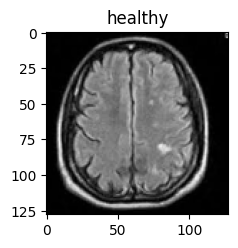

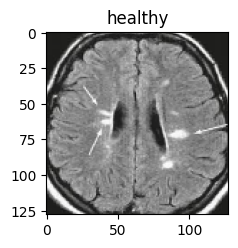

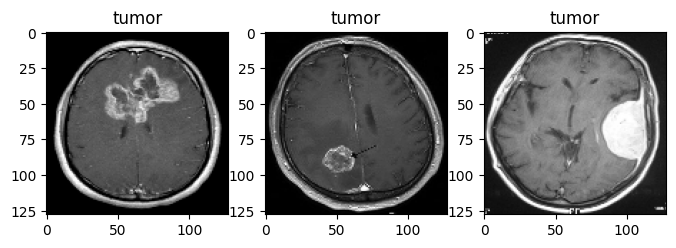

In [29]:
plot_random(healthy,tumor,num=3)

Create Torch Dataset Class